In [19]:
# Import Libraries

In [20]:
import os

# print the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)



Current working directory: D:\10 acadamy\solar-challenge-week1


In [21]:
# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from windrose import WindroseAxes




# Set working directory to project root
os.chdir(r"D:\10 acadamy\solar-challenge-week1")
print("Current working directory:", os.getcwd())







ModuleNotFoundError: No module named 'windrose'

In [ ]:
#load data 

In [ ]:
import pandas as pd
import os

# Set working directory to project root
os.chdir(r"D:\10 acadamy\solar-challenge-week1")
print("Current working directory:", os.getcwd())

df = pd.read_csv("data/sierraleone_bumbna_raw.csv", low_memory=False)
df.head()

Current working directory: D:\10 acadamy\solar-challenge-week1


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,yyyy-mm-dd hh:mm,W/m�,W/m�,W/m�,W/m�,W/m�,�C,%,m/s,m/s,m/s,�N (to east),�,hPa,1 or 0,mm/min,�C,�C,NaN
1,2021-10-30 00:01,-0.7,-0.1,-0.8,0,0,21.9,99.1,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
2,2021-10-30 00:02,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
3,2021-10-30 00:03,-0.7,-0.1,-0.8,0,0,21.9,99.2,0,0,0,0,0,1002,0,0,22.3,22.6,NaN
4,2021-10-30 00:04,-0.7,0,-0.8,0,0,21.9,99.3,0,0,0,0,0,1002,0,0.1,22.3,22.6,NaN


In [ ]:
#Summary stats & missing-value report

In [ ]:
# numeric summary
display(df.describe())

# count nulls per column
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls)

# list columns with >5% nulls
pct_null = (df.isna().mean() * 100).sort_values(ascending=False)
cols_gt5 = pct_null[pct_null > 5.0]
print("Columns with >5% missing:\n", cols_gt5)


,Comments
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


Comments         525601
GHI                   0
Timestamp             0
DNI                   0
DHI                   0
ModB                  0
ModA                  0
RH                    0
WS                    0
WSgust                0
Tamb                  0
WSstdev               0
WD                    0
BP                    0
WDstdev               0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
dtype: int64

Columns with >5% missing:
 Comments    100.0
dtype: float64


In [ ]:
#Outlier detection (Z-score) & flagging

In [ ]:
# -----------------------------
# Outlier detection (safe)
# -----------------------------
import numpy as np

# Columns to check
cols_to_z = ['GHI','DNI','DHI','Tamb','WS']
cols_to_z = [c for c in cols_to_z if c in df.columns]

# Ensure all selected columns are numeric
df[cols_to_z] = df[cols_to_z].apply(pd.to_numeric, errors='coerce')

# Compute z-scores ignoring NaNs
z_df = df[cols_to_z].apply(lambda x: (x - x.mean()) / x.std(ddof=0))

# Flag outliers where |z| > 3
df['outlier_flag'] = (np.abs(z_df) > 3).any(axis=1)

# Print count safely
outlier_count = df['outlier_flag'].sum()
print("Outliers found:", outlier_count)


Outliers found: 15645


In [ ]:
#Drop or impute missing values

In [ ]:
key_cols = [c for c in ['GHI','DNI','DHI','ModA','ModB','WS','WSgust','Tamb','RH'] if c in df.columns]

# show how many nulls remain
print(df[key_cols].isna().sum())

# median impute:
for c in key_cols:
    if df[c].isna().sum() > 0:
        median = df[c].median()
        df[c] = df[c].fillna(median)


GHI       1
DNI       1
DHI       1
ModA      0
ModB      0
WS        1
WSgust    0
Tamb      1
RH        0
dtype: int64


In [ ]:
#Export cleaned CSV (ensure data/ is ignored)

In [ ]:
import os

# Make sure data folder exists
os.makedirs("data", exist_ok=True)

# Save to data folder in project root
clean_path = "data/sierraleone_clean.csv"
df.to_csv(clean_path, index=False)
print("✅ Saved cleaned CSV to", clean_path)

✅ Saved cleaned CSV to data/sierraleone_clean.csv


In [ ]:
#Time-series analysis & plots

In [ ]:
df = df.rename(columns={
    'Global_Horizontal_Irradiance': 'GHI',
    'Direct_Normal_Irradiance': 'DNI',
    'Diffuse_Horizontal_Irradiance': 'DHI',
    'Temperature': 'Tamb'
})


In [ ]:
#Cleaning impact (pre/post)

In [ ]:
df = df.rename(columns={
    'GHI (W/m²)': 'GHI',
    'DNI (W/m²)': 'DNI',
    'DHI (W/m²)': 'DHI',
    'Temp (°C)': 'Tamb',
    'RH (%)': 'RH',              # add this line for Relative Humidity
    'Pressure (hPa)': 'BP',      # optional, if you want to use Pressure in bubble chart
    'Wind Speed (m/s)': 'WS',    # optional, if you want WS plots
    # add any other columns you want to simplify names
})



In [ ]:
df.columns.tolist()


['Timestamp',
 'GHI',
 'DNI',
 'DHI',
 'ModA',
 'ModB',
 'Tamb',
 'RH',
 'WS',
 'WSgust',
 'WSstdev',
 'WD',
 'WDstdev',
 'BP',
 'Cleaning',
 'Precipitation',
 'TModA',
 'TModB',
 'Comments',
 'outlier_flag']

In [ ]:
#Correlation & scatter plots

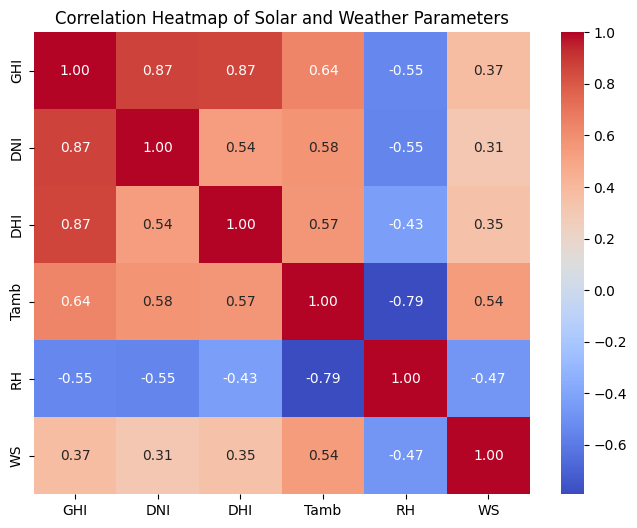

In [ ]:
# Make sure numeric columns are numeric
corr_cols = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS']
corr_cols = [c for c in corr_cols if c in df.columns]

# Convert to numeric (coerce invalid entries to NaN)
df[corr_cols] = df[corr_cols].apply(pd.to_numeric, errors='coerce')

# Optional: drop rows with NaN in these columns to avoid issues
df_corr = df[corr_cols].dropna()

# Plot correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_corr.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Solar and Weather Parameters")
plt.show()

In [ ]:
#Wind & distribution analysis

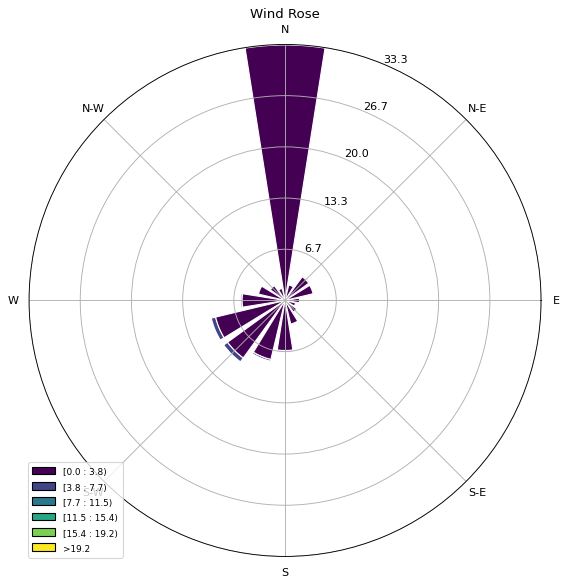

In [ ]:
# Ensure numeric types for Wind Speed and Wind Direction
df['WS'] = pd.to_numeric(df['WS'], errors='coerce')   # invalid parsing becomes NaN
df['WD'] = pd.to_numeric(df['WD'], errors='coerce')

# Fill missing values (NaN) with 0 or median
df['WS'] = df['WS'].fillna(0)
df['WD'] = df['WD'].fillna(0)

# Now create the wind rose
if 'WD' in df.columns and 'WS' in df.columns:
    from windrose import WindroseAxes
    import matplotlib.pyplot as plt

    ax = WindroseAxes.from_ax()
    ax.bar(df['WD'], df['WS'], normed=True, opening=0.8, edgecolor='white')
    ax.set_legend()
    plt.title("Wind Rose")
    plt.show()


In [ ]:
#Temperature & humidity relationships

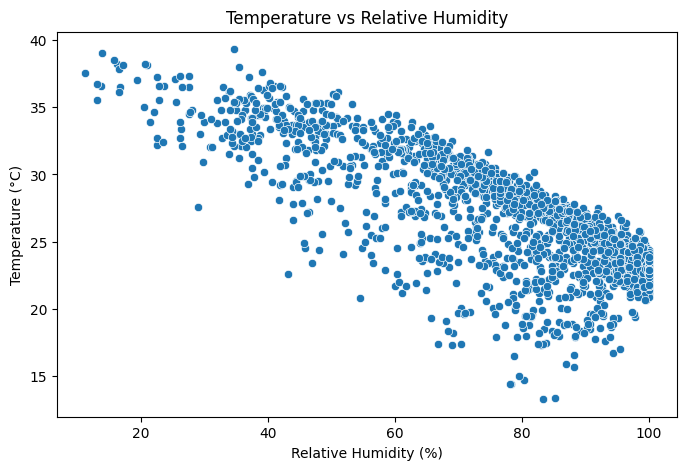

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='RH', y='Tamb', data=df.sample(n=2000) if len(df)>2000 else df)
plt.title("Temperature vs Relative Humidity")
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Temperature (°C)")
plt.show()


In [ ]:
#Bubble chart

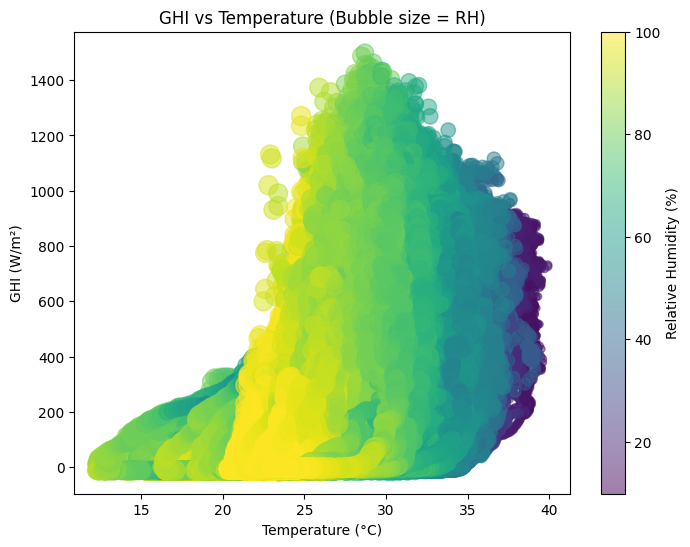

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(
    df['Tamb'], 
    df['GHI'], 
    s=df['RH']*2,   # scale bubble size for visibility
    c=df['RH'],     # color by RH too
    alpha=0.5, 
    cmap='viridis'
)
plt.colorbar(label='Relative Humidity (%)')
plt.xlabel("Temperature (°C)")
plt.ylabel("GHI (W/m²)")
plt.title("GHI vs Temperature (Bubble size = RH)")
plt.show()


In [ ]:
# Save cleaned 

In [ ]:
import os

# Make sure data folder exists
os.makedirs("data", exist_ok=True)

# Save to data folder in project root
clean_path = "data/sierraleone_clean.csv"
df.to_csv(clean_path, index=False)
print("✅ Saved cleaned CSV to", clean_path)
os.makedirs("data", exist_ok=True)



✅ Saved cleaned CSV to data/sierraleone_clean.csv
